# Constructing discount, yield and forward curves using Exact Methods

This exercise is derived from 'Interest Rates Models' by Damir Filipovic. all explanations on the content is based on my understanding from taking the online MOOC. For more information of the MOOC, please refer to https://www.coursera.org/learn/interest-rate-models.

In this tutorial, we will be exploring the use of Bootstrapping method and Pseudo-Inverse methods in constructing discount curves. These two methods fall within the branch of Exact methods, a general approach of utilising available market data and aims to fit the curve to the market data as close as possible. Exact methods are largely used by rates traders in order to price the interest rates instruments. <br>

On top of introducing the methods, we shall also evaluate the pros and cons of each method, and also the tools that could be more suitable to implement this exercise.

In [1]:
# Essential libraries for this exercise
import pandas as pd # Dataframe construction
import numpy as np # Linear algebra operations (largely used in Pseudo-inverse method)
import os # For navigating directories
from datetime import datetime, timedelta # Handling datetime data
import matplotlib.pyplot as plt # Plotting

%matplotlib inline

## Obtaining market data for yield curve construction

As mentioned earlier, we need to import market data available for exact method, and the longer the maturity, the more informative the discount curve. Here, we shall download the data from a csv file prepared beforehand. This file contains a collection of LIBOR rates (overnight, 1-month, 3-month, 6-month), futures prices (Jun-13, Sep-13, Dec-13, Mar-14 expiries), and swap rates (2y, 3y, 4y, 5y, 7y, 10y, 15y, 20y, 30y).<br>

The spot date here is 3rd October 2012. <br>

Some assumptions:
- the reset date for futures is 3 months (91 days) prior to the contract's expiry/ maturity
- the swaps given is a spot swap with reset date $U_0$ at the spot date
- the swaps incur cashflows on an annual basis, and is exactly 365 days from the previous available date (if interpolation is required)
- the day convention used in these instrument is $\frac{Actual}{360 days}$, and $\delta(T_i,T_0) = \frac{T_i - T_0}{360}$, where $T_i$ and $T_0$ are dates

In [2]:
this_path = os.getcwd()
market_quotes = pd.read_csv(os.path.join(this_path,'Practice Datasets','market_quotes.csv'))
market_quotes['Maturity Dates'] = pd.to_datetime(market_quotes['Maturity Dates'], format = '%d/%m/%Y')

# Display a list of market data
market_quotes

,Maturity Dates,Market Quotes,Source
0,2012-10-04,0.095,LIBOR
1,2012-11-05,0.116,LIBOR
2,2013-01-03,0.223,LIBOR
3,2013-04-03,0.438,LIBOR
4,2013-06-19,99.786,Futures
5,2013-09-18,99.752,Futures
6,2013-12-18,99.723,Futures
7,2014-03-19,99.669,Futures
8,2014-10-03,0.475,Swap
9,2015-10-05,0.586,Swap


# Constructing discount curve using Bootstrapping Method

For the first example, we shall explore the use of bootstrapping method.<br>

By principle, the bootstrapping method make use of available market data to derive the discount factor for each interval/ reset date. When there is no market data for an interval, interpolation will be used to find the simple spot rate in order to derive the discount factor.<br>

As the calculation differs for LIBOR, futures and swap, we shall process each data separately.

In [3]:
# Split the data into the different sources
libor_quotes = market_quotes[market_quotes['Source']=='LIBOR'].copy()
futures_quotes = market_quotes[market_quotes['Source']=='Futures'].copy()
swap_quotes = market_quotes[market_quotes['Source']=='Swap'].copy()

## Cleaning up Libor quotes and determine discount factors

The given LIBOR rate are displayed in percentages. As these rates are simple rates, the discounted factor equation is as follows:<br>
$P(t_0, t_i) = \frac{1}{1+\delta(t_0,t_i)L(t_0,t_i)}$<br>

In [4]:
def interpolation(T0, T1, T2, R0, R2):
    # Create an interpolation function when interpolation is required to fill the missing maturities
    try:
        return (T1 - T0).days/(T2 - T0).days*(R2 - R0) + R0
    except:
        return (T1 - T0).astype('timedelta64[D]')/ (T2 - T0).astype('timedelta64[D]')*(R2 - R0) + R0

In [5]:
spot_date = datetime. strptime('3/10/2012', '%d/%m/%Y') # Define spot date
day_convention = 1/360 # Define day convention: Actual/360

# Add spot data into the libor quotes df
libor_quotes = libor_quotes.append({'Maturity Dates': datetime.strptime('20/3/2013', '%d/%m/%Y'),\
                                    'Market Quotes': interpolation(libor_quotes.iloc[2,0],\
                                                                   datetime.strptime('20/3/2013', '%d/%m/%Y'),\
                                                                   libor_quotes.iloc[3,0],\
                                                                   libor_quotes.iloc[2,1],\
                                                                   libor_quotes.iloc[3,1]),\
                                   'Source' : 'LIBOR'}, ignore_index = True)

libor_quotes = libor_quotes.sort_values(by = 'Maturity Dates')
libor_quotes['Delta'] = day_convention*((libor_quotes['Maturity Dates'] - spot_date).dt.days)

# Calculate discount price
libor_quotes['Discount factor'] = 1/(1+libor_quotes['Delta']*libor_quotes['Market Quotes']/100)
libor_quotes

,Maturity Dates,Market Quotes,Source,Delta,Discount factor
0,2012-10-04,0.095000,LIBOR,0.002778,0.999997
1,2012-11-05,0.116000,LIBOR,0.091667,0.999894
2,2013-01-03,0.223000,LIBOR,0.255556,0.999430
4,2013-03-20,0.404556,LIBOR,0.466667,0.998116
3,2013-04-03,0.438000,LIBOR,0.505556,0.997791


## Cleaning up futures quotes and determine discount prices

As defined, the reset date for the futures is 3 months prior. To find the discount factor, we apply the following equation: <br>
$P(t,T_i) = \frac{P(t,T_0)}{1+\delta(T_0,T_i) F(t,T_0,T_1)}$<br>

For the first futures with Jun-2013 expiry, the reset date $T_0$ is on 20th March 2013. We have previously solved for the discount factor $P(t,T_0)$ using interpolation when solving for the discount factors from the LIBORs.<br>

Another point to note: Here, we such take the futures rates as a proxy to the forward rate, whereby<br>
$F_{forward}(t,T_0,T_1) \approx F_{futures}(t,T_0,T_1) = 1 - \frac{P_{futures}}{100}$

In [6]:
futures_quotes['Forward rates'] = 1-futures_quotes['Market Quotes']/100

# Calculate delta
futures_quotes['Delta'] = day_convention*(futures_quotes['Maturity Dates'] - futures_quotes['Maturity Dates'].shift(1)).dt.days
# Calculate the delta for the front month futures contract, based on the first reset date
futures_quotes.iloc[0,4] = day_convention*(futures_quotes.iloc[0,0] - datetime. strptime('20/3/2013', '%d/%m/%Y')).days

futures_quotes

,Maturity Dates,Market Quotes,Source,Forward rates,Delta
4,2013-06-19,99.786,Futures,0.00214,0.252778
5,2013-09-18,99.752,Futures,0.00248,0.252778
6,2013-12-18,99.723,Futures,0.00277,0.252778
7,2014-03-19,99.669,Futures,0.00331,0.252778


In [7]:
def get_discount_factor_futures(df,i,start_price):
    '''
    Description: This is an iterative function which will return a list of discount factors based on the futures rates given
    The function is provided with the dataframe with the futures quotes and delta information, an number i which represents
    the number of row to screen through (i.e. the no. of rows in the df), and the discount factor at the first reset date 
    ("start_price"). The function then searches through the earliest futures, calculate the discount factor with the 
    start_price, which would then be used to calculate the next discount factor. All results will be appended into a list
    and be passed back to the previous iteration until the iteration is over.
    '''
    delta = df.iloc[i, 4]
    forward_rate = df.iloc[i,3]
    if i > 0:
        prices = get_discount_factor_futures(df, i-1, start_price)
        price_i = prices[i-1]/(1 + delta*forward_rate)
        prices.append(price_i)
        return prices
    else:
        return [start_price/(1+delta*forward_rate)]

In [8]:
futures_discount_factors = get_discount_factor_futures(futures_quotes,futures_quotes.shape[0]-1,libor_quotes.iloc[3,4])
futures_quotes['Discount factor'] = futures_discount_factors
futures_quotes

,Maturity Dates,Market Quotes,Source,Forward rates,Delta,Discount factor
4,2013-06-19,99.786,Futures,0.00214,0.252778,0.997576
5,2013-09-18,99.752,Futures,0.00248,0.252778,0.996951
6,2013-12-18,99.723,Futures,0.00277,0.252778,0.996253
7,2014-03-19,99.669,Futures,0.00331,0.252778,0.995421


## Cleaning up swap quotes and determine discount prices

Before we delve into the discount factor calculations from the swap quote, we need to first calculate the discount factor at the swap reset date $U_1$, which is on 3rd October 2013, one year from the spot date. To do so, we will first clean up our discount factors into a dataframe, and solve for the discount factor at the swap reset date - through interpolation.

In [9]:
# Consolidate all the discount factors we have calculated from the LIBOR and futures quotes

discount_factors = libor_quotes[['Maturity Dates', 'Discount factor']].append(futures_quotes[['Maturity Dates',\
                                                                                              'Discount factor']])
discount_factors = discount_factors.sort_values(by = 'Maturity Dates').reset_index(drop = True)
discount_factors['Delta'] = day_convention*((discount_factors['Maturity Dates'] - spot_date).dt.days)
discount_factors['Spot rates'] = (1/discount_factors['Discount factor']-1)/discount_factors['Delta']
discount_factors

,Maturity Dates,Discount factor,Delta,Spot rates
0,2012-10-04,0.999997,0.002778,0.000950
1,2012-11-05,0.999894,0.091667,0.001160
2,2013-01-03,0.999430,0.255556,0.002230
3,2013-03-20,0.998116,0.466667,0.004046
4,2013-04-03,0.997791,0.505556,0.004380
5,2013-06-19,0.997576,0.719444,0.003377
6,2013-09-18,0.996951,0.972222,0.003146
7,2013-12-18,0.996253,1.225000,0.003070
8,2014-03-19,0.995421,1.477778,0.003113


In [10]:
# reset date for swap U1 is one year after spot date, i.e. 3/10/2013
reset_date = datetime.strptime('3/10/2013', '%d/%m/%Y')
delta_reset = day_convention*(reset_date - spot_date).days

# Calculate the spot rate at the swap reset date
spot_reset = interpolation(discount_factors.iloc[6,0],\
                           reset_date,\
                           discount_factors.iloc[7,0],\
                           discount_factors.iloc[6,3],\
                           discount_factors.iloc[7,3],)

# Calculate the discount factor at the swap reset date
discount_reset = 1/(1+delta_reset*spot_reset)

# Append the data from the swap reset date onto the discount factor df
discount_factors = discount_factors.append({'Maturity Dates': reset_date,\
                                         'Discount factor': discount_reset,\
                                         'Delta': delta_reset,\
                                         'Spot rates': spot_reset},\
                                         ignore_index = True)

# Sort the rows in the dataframe by the maturity dates
discount_factors = discount_factors.sort_values(by = 'Maturity Dates').reset_index(drop = True)
discount_factors

,Maturity Dates,Discount factor,Delta,Spot rates
0,2012-10-04,0.999997,0.002778,0.000950
1,2012-11-05,0.999894,0.091667,0.001160
2,2013-01-03,0.999430,0.255556,0.002230
3,2013-03-20,0.998116,0.466667,0.004046
4,2013-04-03,0.997791,0.505556,0.004380
5,2013-06-19,0.997576,0.719444,0.003377
6,2013-09-18,0.996951,0.972222,0.003146
7,2013-10-03,0.996833,1.013889,0.003133
8,2013-12-18,0.996253,1.225000,0.003070
9,2014-03-19,0.995421,1.477778,0.003113


Now that we are ready, let's proceed with the discount factor calculations from the swap quotes.

In [11]:
# Display the swap quotes
swap_quotes

,Maturity Dates,Market Quotes,Source
8,2014-10-03,0.475,Swap
9,2015-10-05,0.586,Swap
10,2016-10-03,0.752,Swap
11,2017-10-03,0.942,Swap
12,2019-10-03,1.324,Swap
13,2022-10-03,1.739,Swap
14,2027-10-04,2.165,Swap
15,2032-10-04,2.280,Swap
16,2042-10-03,2.332,Swap


In [12]:
# Create 2 arrays containing 2 sets of key data - Maturity dates and Market Quotes
swap_maturities = np.array(swap_quotes['Maturity Dates'])
swap_rates = np.array(swap_quotes['Market Quotes'])

iterations = len(swap_maturities)
for i in range(iterations - 1):
    # Iterate through all available maturities within the swap quotes
    if (swap_maturities[i+1] - swap_maturities[i]).astype('timedelta64[D]')/ np.timedelta64(1, 'D') > 370:
        '''
        When there are "gaps" in the swap quotes - meaning that two adjacent maturities are more than one year,
        (recall that cashflows of swap should be annual), we will use interpolation to calculate the intermediate swap rates
        with expirations on those intermediate periods.
        '''
        # Calculate the "gap" (in units of years)
        year_delta = (swap_maturities[i+1] - swap_maturities[i]).astype('timedelta64[D]')/ np.timedelta64(365, 'D')
        
        # Create an array of expiries to fill the gap - assume cash flows are on exactly 365 days interval
        intermediate_maturities = [swap_maturities[i] + j*np.timedelta64(365, 'D') for j in range(1,int(year_delta))]
        
        # Create swap rates using interpolation
        intermediate_swap_rates = [interpolation(swap_maturities[i],\
                                                 T,\
                                                 swap_maturities[i+1],\
                                                 swap_rates[i],\
                                                 swap_rates[i+1]) for T in intermediate_maturities]
        
        # Insert intermediate maturities and swap rates into the two arrays created
        swap_maturities = np.append(swap_maturities, intermediate_maturities)
        swap_rates = np.append(swap_rates, intermediate_swap_rates)

# Create a swap rates dataframe with the maturities and the swap rates, sorted by maturities
interpolated_swap_quotes = pd.DataFrame({'Maturity Dates': swap_maturities, 'Swap Rates': swap_rates})
interpolated_swap_quotes = interpolated_swap_quotes.sort_values(by = 'Maturity Dates').reset_index(drop = True)

# Calculate delta of two adjacent maturities
interpolated_swap_quotes['Delta'] = day_convention*(interpolated_swap_quotes['Maturity Dates'] - interpolated_swap_quotes['Maturity Dates'].shift(1)).dt.days
interpolated_swap_quotes.iloc[0,2] = day_convention*(interpolated_swap_quotes.iloc[0,0] - reset_date).days
interpolated_swap_quotes

,Maturity Dates,Swap Rates,Delta
0,2014-10-03,0.475000,1.013889
1,2015-10-05,0.586000,1.019444
2,2016-10-03,0.752000,1.011111
3,2017-10-03,0.942000,1.013889
4,2018-10-03,1.133000,1.013889
5,2019-10-03,1.324000,1.013889
6,2020-10-02,1.462207,1.013889
7,2021-10-02,1.600414,1.013889
8,2022-10-03,1.739000,1.016667
9,2023-10-03,1.824107,1.013889


Recall: To find swap rate,<br>
$R_{Swap} = \frac{P(t,T_1)-P(t,T_N)}{\sum_{i=1}^{N}(\delta(T_i,T_{i-1})\times P(t,T_i))}$<br>

Thus, to find the discount factor $P(t,T_N)$:
$P(t,T_N) = \frac{1-R_{Swap}\times \sum_{i=1}^{N-1} \delta(T_{i-1},T_i)\times P(t,T_i)}{1+R_{Swap}\times \delta(T_{N-1},T_N)}$

In [13]:
# Create an array for swap discount factors, and initiate it with the discount factor on the swap reset date
swap_discount_factors = np.array(discount_factors.iloc[7,1]).reshape(-1,1)

# Extract swap maturities, swap rates and swap delta (adjacent maturities)
swap_maturities = np.array(interpolated_swap_quotes['Maturity Dates']).reshape(-1,1)
swap_rates = np.array(interpolated_swap_quotes['Swap Rates']).reshape(-1,1)/100
swap_delta = np.array(np.append(np.array(discount_factors.iloc[7,2]), interpolated_swap_quotes['Delta'])).reshape(-1,1)

def get_discount_factor_swaps(i, swap_rate, delta_array, discount_array):
    '''
    Implement the discount factor equations given the swap rates
    '''
    return (1-swap_rate*np.sum(np.multiply(delta_array[:i+1], discount_array)))/(1+swap_rate*delta_array[i+1][0])

In [14]:
for i in range(len(swap_maturities)):
    print('Calculating discount factor for U{}...'.format(i+1))
    swap_rate = swap_rates[i][0]
    
    delta_array = swap_delta[:i+2]
    discount_array = swap_discount_factors.reshape(-1,1)
    swap_discount_factors = np.append(swap_discount_factors, get_discount_factor_swaps(i,\
                                                                                       swap_rate,\
                                                                                       delta_array,\
                                                                                       discount_array))
    
    print('swap rate: {0}, delta: {1}, discount factor: {2}.'.format(swap_rate, delta_array[i+1],swap_discount_factors[-1]))
    print('===============================================================\n')


Calculating discount factor for U1...
swap rate: 0.00475, delta: [1.01388889], discount factor: 0.9904293978118072.

Calculating discount factor for U2...
swap rate: 0.00586, delta: [1.01944444], discount factor: 0.9823245469254512.

Calculating discount factor for U3...
swap rate: 0.00752, delta: [1.01111111], discount factor: 0.9699424956658134.

Calculating discount factor for U4...
swap rate: 0.009420000000000001, delta: [1.01388889], discount factor: 0.9532439057414133.

Calculating discount factor for U5...
swap rate: 0.01133, delta: [1.01388889], discount factor: 0.9330454065802974.

Calculating discount factor for U6...
swap rate: 0.01324, delta: [1.01388889], discount factor: 0.9095485893868868.

Calculating discount factor for U7...
swap rate: 0.014622071167883213, delta: [1.01388889], discount factor: 0.8869574428296384.

Calculating discount factor for U8...
swap rate: 0.016004142335766424, delta: [1.01388889], discount factor: 0.8622809793033823.

Calculating discount fact

In [15]:
swap_discount_df = pd.DataFrame({'Maturity Dates': swap_maturities.flatten(),\
                                 'Discount factor': swap_discount_factors[1:].flatten()})

bootstrap_df = discount_factors[['Maturity Dates', 'Discount factor']].append(swap_discount_df)
bootstrap_df = bootstrap_df.sort_values(by = 'Maturity Dates').reset_index(drop = True)

# Calculate spot rates
bootstrap_df['Delta(t_i, t_0)'] = day_convention*(bootstrap_df['Maturity Dates'] - spot_date).dt.days
bootstrap_df['Spot rates'] = (1/bootstrap_df['Discount factor']-1)/bootstrap_df['Delta(t_i, t_0)']

# Calculate yield
bootstrap_df['Yield'] = -np.log(bootstrap_df['Discount factor'])/bootstrap_df['Delta(t_i, t_0)']

# Calculate implied forward rates
bootstrap_df['Delta(t_i, t_i-1)'] = day_convention*(bootstrap_df['Maturity Dates'] - bootstrap_df['Maturity Dates'].shift(1)).dt.days
bootstrap_df.iloc[0,4] = day_convention*(bootstrap_df.iloc[0,0] - spot_date).days
bootstrap_df['Implied forward rates'] = 1/bootstrap_df['Delta(t_i, t_i-1)'] * np.log(bootstrap_df['Discount factor'].shift(1)/bootstrap_df['Discount factor'])
bootstrap_df.iloc[0,5] = bootstrap_df.iloc[0,3]

bootstrap_df

,Maturity Dates,Discount factor,"Delta(t_i, t_0)",Spot rates,Yield,"Delta(t_i, t_i-1)",Implied forward rates
0,2012-10-04,0.999997,0.002778,0.000950,0.002778,0.000950,NaN
1,2012-11-05,0.999894,0.091667,0.001160,0.001160,0.088889,0.001166
2,2013-01-03,0.999430,0.255556,0.002230,0.002229,0.163889,0.002828
3,2013-03-20,0.998116,0.466667,0.004046,0.004042,0.211111,0.006236
4,2013-04-03,0.997791,0.505556,0.004380,0.004375,0.038889,0.008376
5,2013-06-19,0.997576,0.719444,0.003377,0.003373,0.213889,0.001005
6,2013-09-18,0.996951,0.972222,0.003146,0.003141,0.252778,0.002479
7,2013-10-03,0.996833,1.013889,0.003133,0.003128,0.041667,0.002833
8,2013-12-18,0.996253,1.225000,0.003070,0.003064,0.211111,0.002756
9,2014-03-19,0.995421,1.477778,0.003113,0.003106,0.252778,0.003309


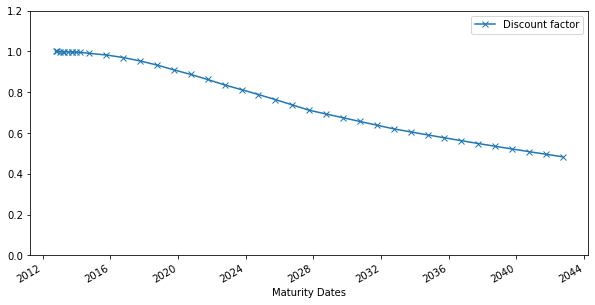

In [16]:
bootstrap_df.plot.line(x = 'Maturity Dates', y = 'Discount factor', marker='x', ylim = (0,1.2), figsize = (10,5))
plt.show()

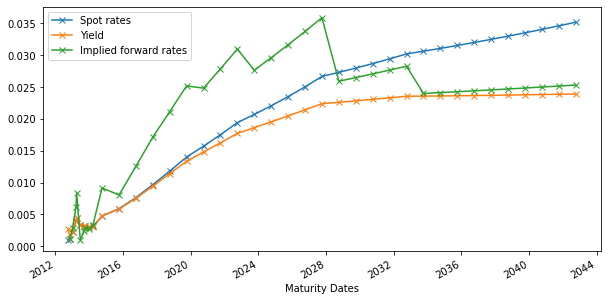

In [17]:
bootstrap_df.plot.line(x = 'Maturity Dates', y = ['Spot rates', 'Yield','Implied forward rates'], marker='x', figsize = (10,5))
plt.show()

---

# Constructing yield curve using Pseudoinverse Method

As earlier demonstrated, bootstrap method focuses on estimating the discount factors via various interpolation. Interpolations here is required because there are a total of 39 cash flow periods, but there are only 17 reference rates available. Mathematically speaking, with 39 unknown variables and 17 equations, we are left with a discount curve that has infinite solutions. Bootstrapping method thus helps to fill the "gaps" by estimating the remaining 22 equations.<br>

However, instead of estimating the discount factors, we may instead treat this as an optimization problem to find a minimal norm. This is where Pseudo-inverse method comes about.<br>

Some basic theory here (for more information, please refer to https://arxiv.org/pdf/1606.03899.pdf):<br>

## Creating a linear system describing the price, cashflows and discount vectors
$Cd = p$<br>
Where $C$ is the cash-flow matrix (17 x 39), $p$ is the price vector, made of prices at $T_0$ (17 x 1), $d$ is the discount vector (39 x 1).<br>

For LIBOR:
- price $p = 1$ at $t=0$
- cashflow $c = 1 + \delta(T)L(0,T)$ at maturity $t = T$

For futures:
- price $p = 0$ at $t = 0$
- cashflow $c_{T_0} = -1$ at $t = T_0$, where $T_0$ is the reset date of the futures
- cashflow $c_{T} = 1 + \delta(T,T_0)F(0,T_0,T)$ at maturity $t = T$

For (spot) swaps:
- price $p = 0$ at $t = 0$
- cashflow $c_{i} = \delta(T_i,T_{i-1})K$ for $i < N$, where $T_N$ is the maturity
- cashflow $c_N = 1 + \delta(T_N,T_{N-1})K$ at maturity $t = T_N$


## Weighted increments
In this method, instead of estimating the discount curve directly, we shall estimate the <i>weighted increments</i>.<br>
Weighted increment vector is defined as: $\Delta = (\frac{P_{T_0} - P_{T_1}}{\sqrt{\delta(T_1,T_0)}}, \frac{P_{T_1} - P_{T_2}}{\sqrt{\delta(T_2,T_1)}}, ..., \frac{P_{T_{N-1}} - P_{T_N}}{\sqrt{\delta(T_N,T_{N-1})}})^T$.<br>

Generally, weighted increments are helpful for our discount curve construction as the square of sum of the weighted increment would make up the first order approximation of the discount curve equation:<br>
$||\Delta||^2 = \sum_{i=1}^N |\frac{P_{T_{i-1}}-P_{T_i}}{\sqrt{\delta(T_i,T_{i-1})}}|^2 \approx \int_{T_0}^{T_N} |\partial_T P(T_0,T)|^2 dT $<br>

The weighted increment vector is related to the discount vector as follows: $\Delta = W(Md - (1,0,...,0)^T)$, where<br>
- $W$ is a diagonal vector of power inverse of the square root of time difference $\frac{1}{\sqrt{\delta(T_i,T_{i-1})}}$
- $M = \begin{pmatrix} 1 & 0 & \dots & \dots & 0 \\  -1 & 1 & 0 & \ddots & 0 \\ 0 & -1 & \ddots & \ddots & 0 \\ \vdots & \vdots & \ddots & \ddots & 0 \\ 0 & \dots & 0 & -1 & 1\end{pmatrix}$

Relating the linear system with the weighted increments, we get:<br>
$CM^{-1}W^{-1}\Delta = p - CM^{-1}(1,0,...,0)^T$

## Estimating $\Delta$ via Pseudo-inverse method
Assuming that matrix $A = CM^{-1}W^{-1}$ is full-ranked, then the Pseudo-inverse<br>
$\Delta^* = A^T(AA^T)^{-1}(p - CM^{-1}(1,0,...,0)^T)$ would be the solution of $\Delta$ with minimal Euclidean norm.<br>

## Deriving discount vector
Once we have solved for $\Delta^*$, substitute it to find $d = M^{-1}(W^{-1}\Delta^* + (1,0,...,0)^T)$.

In [18]:
# Review the market quotes again
market_quotes

,Maturity Dates,Market Quotes,Source
0,2012-10-04,0.095,LIBOR
1,2012-11-05,0.116,LIBOR
2,2013-01-03,0.223,LIBOR
3,2013-04-03,0.438,LIBOR
4,2013-06-19,99.786,Futures
5,2013-09-18,99.752,Futures
6,2013-12-18,99.723,Futures
7,2014-03-19,99.669,Futures
8,2014-10-03,0.475,Swap
9,2015-10-05,0.586,Swap


In [19]:
# Retrieve all cashflow dates and delta
dates = np.append(spot_date.date(),np.array(bootstrap_df['Maturity Dates'].dt.date))
spot_delta = np.array(bootstrap_df['Delta(t_i, t_0)'])

def cash_flows(row, dates, spot_delta = None, swap_reset_date = None):
    cashflows = np.zeros(dates.shape[0])
    '''
    Three modes of calculation (refer to basic theory above):
    1) Cash flow from LIBOR
    2) Cash flow from Futures
    3) Cash flow from spot swap
    '''
    if row['Source'] == 'LIBOR':
        cashflows[0] = 1
        for i in range(1,len(cashflows)):
            cashflows[i] = 1+spot_delta[i-1]*row['Market Quotes']/100 if dates[i] == row['Maturity Dates'].date() else 0
        
    elif row['Source'] == 'Futures':
        for i in range(1,len(cashflows)):
            
            if dates[i] == row['Maturity Dates'].date() - timedelta(days = 91):
                cashflows[i] = -1   
            elif dates[i] == row['Maturity Dates'].date():
                cashflows[i] = 1 + (1-row['Market Quotes']/100)*91/360
            else:
                cashflows[i] = 0
                
    else:
        
        prev_date = spot_date.date()
        cashflows[0] = 1
        for i in range(1,len(cashflows)):
            if dates[i] < prev_date + timedelta(days = 360):
                cashflows[i] = 0
            else:
                delta = day_convention*(dates[i] - prev_date).days
                increments = delta*row['Market Quotes']/100
                if dates[i] == row['Maturity Dates'].date():
                    cashflows[i] = 1 + increments 
                    break
                else:
                    cashflows[i] = increments
                    prev_date = dates[i]
                
    return cashflows
                

In [22]:
# Create the initial cashflow matrix (combination of vector p in the first column and matrix C)
for i in range(market_quotes.shape[0]):
    cash_flow_vector = cash_flows(market_quotes.iloc[i], dates, spot_delta = spot_delta)
    cash_flow_matrix = cash_flow_vector if i == 0 else np.vstack([cash_flow_matrix, cash_flow_vector])


In [23]:
# Create essential matrices - split the initial cashflow matrix into p and C
P = cash_flow_matrix[:,0].reshape(-1,1)
C = cash_flow_matrix[:,1:]

# Create matrix M, M_inverse
M = np.zeros((39,39))
for i in range(39):
    M[i,i] = 1
    if i > 0:
        M[i, i-1] = -1
M_inverse = np.linalg.inv(M)

# Create matrix W, W_invers
step_delta = np.array(bootstrap_df['Delta(t_i, t_i-1)'])
W = np.diag(1/np.sqrt(step_delta))
W_inverse = np.linalg.inv(W)

# Find Delta*
A = np.dot(C, np.dot(M_inverse, W_inverse))
A_T = A.T
LHS_matrix = np.dot(A_T, np.linalg.inv(np.dot(A, A_T)))

single_vector = np.zeros((C.shape[1],1))
single_vector[0] = 1
RHS_matrix = P - np.dot(C, np.dot(M_inverse, single_vector))

delta_asterisk = np.dot(LHS_matrix, RHS_matrix)

# Calculate discount vector using Pseudo-inverse method
discount_vector = np.dot(M_inverse, (np.dot(W_inverse, delta_asterisk)+single_vector))

In [24]:
pseudo_inv_df = pd.DataFrame({'Maturity Dates': np.array(bootstrap_df['Maturity Dates']),\
                              'Discount factor':discount_vector.flatten(),\
                              'Delta(t_i, t_0)':np.array(bootstrap_df['Delta(t_i, t_0)']),\
                              'Delta(t_i, t_i-1)':np.array(bootstrap_df['Delta(t_i, t_i-1)'])
                             })

# Calculate spot rates
pseudo_inv_df['Spot rates'] = (1/pseudo_inv_df['Discount factor']-1)/pseudo_inv_df['Delta(t_i, t_0)']

# Calculate yield
pseudo_inv_df['Yield'] = -np.log(pseudo_inv_df['Discount factor'])/pseudo_inv_df['Delta(t_i, t_0)']

# Calculate implied forward rates
pseudo_inv_df['Implied forward rates'] = 1/pseudo_inv_df['Delta(t_i, t_i-1)'] * np.log(pseudo_inv_df['Discount factor'].shift(1)/pseudo_inv_df['Discount factor'])
pseudo_inv_df.iloc[0,5] = pseudo_inv_df.iloc[0,3]

pseudo_inv_df

,Maturity Dates,Discount factor,"Delta(t_i, t_0)","Delta(t_i, t_i-1)",Spot rates,Yield,Implied forward rates
0,2012-10-04,0.999997,0.002778,0.000950,0.000950,0.000950,NaN
1,2012-11-05,0.999894,0.091667,0.088889,0.001160,0.001160,0.001166
2,2013-01-03,0.999430,0.255556,0.163889,0.002230,0.002229,0.002828
3,2013-03-20,0.997833,0.466667,0.211111,0.004653,0.004648,0.007575
4,2013-04-03,0.997791,0.505556,0.038889,0.004380,0.004375,0.001106
5,2013-06-19,0.997294,0.719444,0.213889,0.003771,0.003766,0.002327
6,2013-09-18,0.996669,0.972222,0.252778,0.003437,0.003432,0.002479
7,2013-10-03,0.996546,1.013889,0.041667,0.003419,0.003413,0.002968
8,2013-12-18,0.995972,1.225000,0.211111,0.003302,0.003295,0.002730
9,2014-03-19,0.995139,1.477778,0.252778,0.003305,0.003297,0.003309


# Comparing the different curves plotted from Bootstrapping method and Pseudo-Inverse method

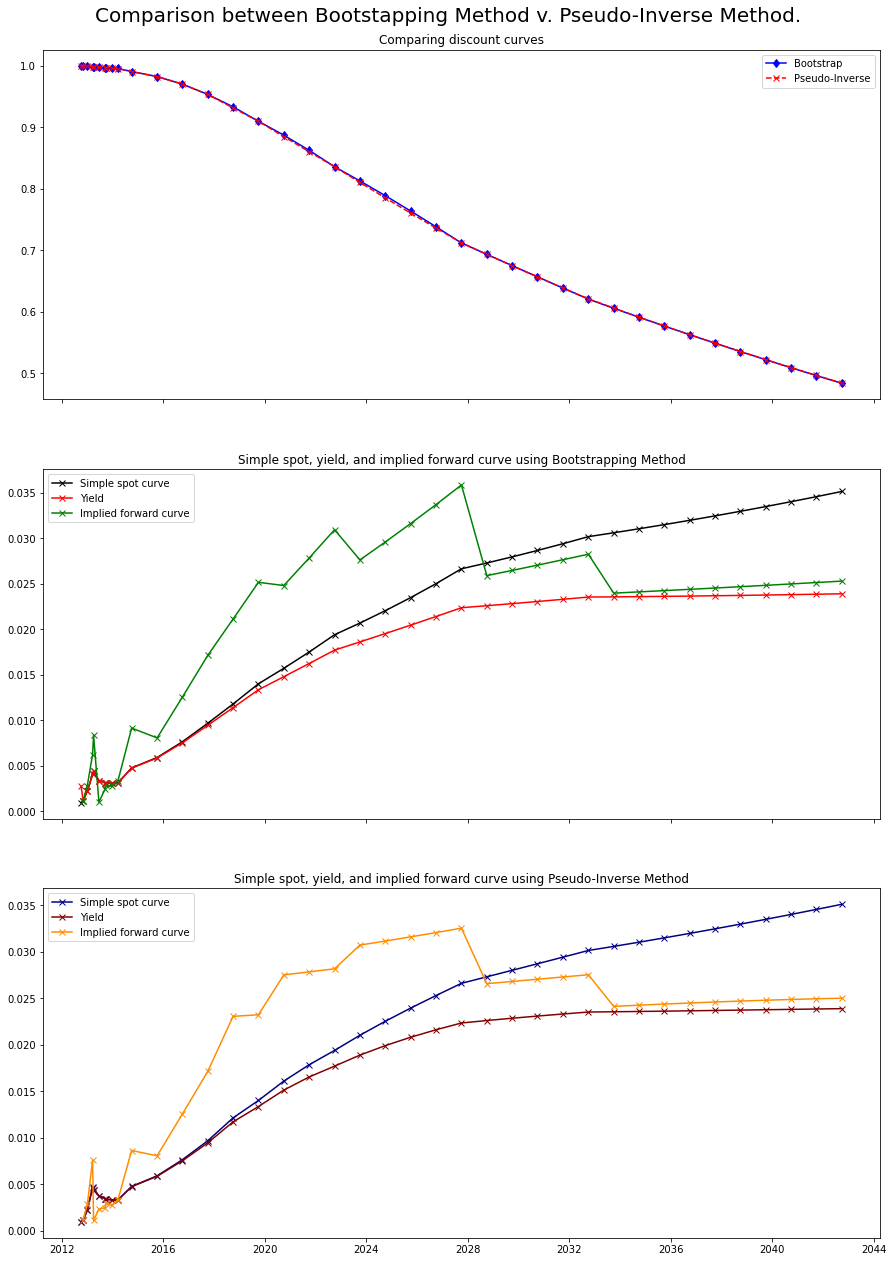

In [25]:
fig, axes = plt.subplots(3,1,figsize=(15,20), sharex = True)
fig.suptitle('Comparison between Bootstapping Method v. Pseudo-Inverse Method.', fontsize=20)
fig.subplots_adjust(top=0.95)

axes[0].plot(bootstrap_df['Maturity Dates'],bootstrap_df['Discount factor'], marker = 'd', color = 'b')
axes[0].plot(pseudo_inv_df['Maturity Dates'],pseudo_inv_df['Discount factor'], marker = 'x', color = 'r', linestyle = '--')
axes[0].set_title('Comparing discount curves')
axes[0].legend(['Bootstrap','Pseudo-Inverse'])

axes[1].plot(bootstrap_df['Maturity Dates'],bootstrap_df['Spot rates'], marker = 'x', color = 'k')
axes[1].plot(bootstrap_df['Maturity Dates'],bootstrap_df['Yield'], marker = 'x', color = 'r')
axes[1].plot(bootstrap_df['Maturity Dates'],bootstrap_df['Implied forward rates'], marker = 'x', color = 'g')
axes[1].set_title('Simple spot, yield, and implied forward curve using Bootstrapping Method')
axes[1].legend(['Simple spot curve','Yield','Implied forward curve'])

axes[2].plot(pseudo_inv_df['Maturity Dates'],pseudo_inv_df['Spot rates'], marker = 'x', color = 'navy')
axes[2].plot(pseudo_inv_df['Maturity Dates'],pseudo_inv_df['Yield'], marker = 'x', color = 'maroon')
axes[2].plot(pseudo_inv_df['Maturity Dates'],pseudo_inv_df['Implied forward rates'], marker = 'x', color = 'darkorange')
axes[2].set_title('Simple spot, yield, and implied forward curve using Pseudo-Inverse Method')
axes[2].legend(['Simple spot curve','Yield','Implied forward curve'])

plt.show()

## Key observations
1) Both methods yield satisfactory results in discount curve and the spot curves; both successfully fitted the market data<br>
2) Implied forward curves from both methods seem to exhibit some discontinuities and are erratic<br>
3) Bootstrapping method exhibits a strong "saw-toothed" pattern on the implied forward curve compared to the pseudo-inverse method<br>


Since pseudo-inverse method is a form of exact smoothing method, it is thus expected that it does not exhibit a stronger "saw-toothed" pattern in the forward curve.<br>

# Conclusion

This exercise has presented two exact solutions to discount curve construction. From this exercise, we experienced that oftentimes we are not presented with market data that allows us to plot the curves easily, and we need to utilize different sources - spot, futures and swaps - in order to estimate the term structure. Naturally, if we wish to explore the term structure with greater maturity, we would require quotes that have longer maturities (usually interest rate swaps). Thus it is important that one is equipped with the knowledge on how to derive the discount factor with the different type of quotes.<br>

Apart from exploring an array of sources, analysts are required to apply different methods and tools for construction. From this example, computational tools such as Python is more compatible as the tool of choice for applying the Pseudo-inverse method than the bootstrapping method. The reason here is that Pseudo-inverse method is an application of linear algebra, and Python happens to be very efficient in solving linear algebra problems. Bootstrapping requires interpolation, and much more planning is required - such as determining reset dates, developing functions to evaluate discount factors for the different types of quotes - and maybe more cumbersome to implement. As such, bootstrapping method is easier to implement by using Microsoft Excel Spreadsheet (which is do-able, considering that the data points are not plenty).